In [1]:
import os
import shutil
import re
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt

load_dotenv()

True

In [2]:
raw_dir = os.getenv("RAW")
nii_dir = os.getenv("NII")
print(nii_dir)

def moveRaw(raw_dir, nii_dir):
    """
    Function for converting files in the raw OAS directory to .nii, then moving them to the specified directory 'nii_dir'
    """
    i=0
    if not os.path.exists(nii_dir):
        os.makedirs(nii_dir)

    # Regex pattern to get the MRI id and visit number
    rawDirPat = r"(?:[\W\S]+?)OAS2_([0-9]{4})_MR([0-2]{1})/RAW"
    for root, dir, files in os.walk(raw_dir):
        r_match = re.findall(rawDirPat, root)
        if len(r_match) > 0:
            subID = r_match[0][0]
            session = r_match[0][1]
            new_name = f"{subID}_{session}"
            for f in files:
                # Get file extension
                fname, fext = os.path.splitext(f)
                # If the file is a .img, it should be converted to .nii
                if fext == ".img":
                    # Get mpr number from file name
                    f_match = re.findall(r"mpr-([0-2]{1}).nifti", fname)
                    if len(f_match) > 0:
                        f_num = f_match[0]

                        # Get full path of .img file
                        img_name = os.path.join(root, (fname + ".img"))

                        # Create new name for .nii file and put it in the right path
                        nii_name = os.path.join(
                            nii_dir, f"OAS2_{subID}_MR{session}_V{f_num}.nifti.nii"
                        )

                        # Load .img image using nibabel
                        img = nib.load(img_name)
                        # print(nii_name)

                        # Save .nii image in nii directory with new name
                        nib.save(img, nii_name)
                        print(f'{i:>4d}/1108 ({i*100./1108.:0>3.2f}%)')
                        # os.remove(os.path.join(root, fname + ".hdr"))
                        # os.remove(os.path.join(root, fname + ".img"))
                        i+=1



if os.getenv("MOVERAW")=="1":
    moveRaw(raw_dir, nii_dir)

/media/brooke-kindleman/Experimenjt/OAS2/datasets/OAS2_NII


Move all files to one directory

In [3]:
from sklearn.model_selection import train_test_split

def makeTVTSplit(df):
  x_train, x_temp, y_train, y_temp = train_test_split(df.drop(columns=["Group"]), df["Group"], test_size=0.2, stratify=df[['Group',"Sex_F"]])

  strat = pd.DataFrame(x_temp)
  strat["Group"] = y_temp

  x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, stratify=strat[['Group',"Sex_F"]],test_size=0.4)
  train = x_train.copy(deep=True)
  train["Split"] = ["train"]*train.shape[0]
  train["Group"] = y_train.values

  validate = x_val.copy(deep=True)
  validate["Split"] = ["validate"]*validate.shape[0]
  validate["Group"] = y_val.values

  test = x_test.copy(deep=True)
  test["Split"] = ["test"]*test.shape[0]
  test["Group"] = y_test.values
  print(f"Split:")
  print(f'\tTest: {len(test)}')
  print(f'\tTrain: {len(train)}')
  print(f'\tValidate: {len(validate)}')

  df_new = pd.merge(train, test, how="outer")
  df_new = pd.merge(df_new, validate, how="outer")

  return df_new

df = pd.read_excel(os.getenv("NORMTAB"))

if os.getenv("SPLITTVT") == "1":
  df_split = makeTVTSplit(df)
  df_split.to_excel(os.getenv("SPLITTAB"))
else:
  df_split = pd.read_excel(os.getenv("SPLITTAB"))

In [4]:
def getImgGroup(filename, df):

  filePattern = r"(OAS2_[0-9]{4}_MR[0-9]{1})"
  r_match = re.match(filePattern, filename)
  split = df[df["MRI ID"]==r_match.groups()[0]]["Group"].values
  if len(split) == 0:
     return -1
  else:
     return split[0]


In [5]:
def toRGB(data):
  """
  Function for converting a numpy array to the proper format to be saved as an RGB image.

  Parameters
  ---------
  data : numpy.ndarray
      Array of data to be converted to image
  """

  x, y = data.shape[:2]
  data = (data-data.min())/(data.max()-data.min())
  img_arr = np.empty(shape=(x,y,4))
  img_arr[:, :, :3] = data
  img_arr[:, :, 3] = 1.
  return img_arr

def cropImg(img_array):
   img_array = img_array[:240, :, :]
   return img_array



def getImgSplit(filename, split_df):

  filePattern = r"(OAS2_[0-9]{4}_MR[0-9]{1})"
  r_match = re.match(filePattern, filename)
  split = split_df[split_df["MRI ID"]==r_match.groups()[0]]["Split"].values
  if len(split) == 0:
     return -1
  else:
     return split[0]

def convertToJPG(nii_dir, jpg_dir, sliceStart,split_df, numImages=1):
    mult = 2
    i = 0
    shape = (0,0,0,0)



    if not os.path.exists(jpg_dir):
       os.makedirs(jpg_dir)

    for root, dir, files in os.walk(nii_dir):

        for f in files:
            fbase, fext = os.path.splitext(f)
            if fext == ".nii":
                i += 1
                fname = os.path.join(root, f)
                img = nib.load(fname)
                for i in range(numImages):
                  data = img.get_fdata()[sliceStart+i*mult,:,:]
                  img_arr = cropImg(toRGB(data))
                  shape = img_arr.shape
                  print(fbase)
                  split=getImgSplit(fbase, split_df)
                  group=getImgGroup(fbase, split_df)
                  if split!=-1 and group!=-1:
                    if False:
                      jpg_name = os.path.join(jpg_dir, split, f'{fbase.replace(".nifti","")}_{sliceStart+i*mult}.jpg')
                    else:
                       jpg_name = os.path.join(jpg_dir, split, f'class_{group}', f'{fbase.replace(".nifti","")}_{sliceStart+i*mult}.jpg')
                    plt.imsave(jpg_name, img_arr)

    return shape

jpg_dir = os.getenv("JPG")
if not os.path.exists(os.path.join(jpg_dir, "test")):
   os.makedirs(os.path.join(jpg_dir, "test"))

for split in ["validate", "train", "test"]:
   if not os.path.exists(os.path.join(jpg_dir, split, "class_0")):
      os.makedirs(os.path.join(jpg_dir, split, "class_0"))
   if not os.path.exists(os.path.join(jpg_dir, split, "class_1")):
      os.makedirs(os.path.join(jpg_dir, split, "class_1"))


data_shape = (240, 128, 4)
if os.getenv("CONVERTJPG") == "1":
   print("convert")
   data_shape = convertToJPG(nii_dir, jpg_dir, 80, df_split, int(os.getenv("NUMSLICES")))

convert
OAS2_0001_MR1_V1.nifti
OAS2_0001_MR1_V1.nifti
OAS2_0001_MR1_V1.nifti
OAS2_0001_MR1_V1.nifti
OAS2_0001_MR1_V2.nifti
OAS2_0001_MR1_V2.nifti
OAS2_0001_MR1_V2.nifti
OAS2_0001_MR1_V2.nifti
OAS2_0001_MR2_V1.nifti
OAS2_0001_MR2_V1.nifti
OAS2_0001_MR2_V1.nifti
OAS2_0001_MR2_V1.nifti
OAS2_0001_MR2_V2.nifti
OAS2_0001_MR2_V2.nifti
OAS2_0001_MR2_V2.nifti
OAS2_0001_MR2_V2.nifti
OAS2_0002_MR1_V1.nifti
OAS2_0002_MR1_V1.nifti
OAS2_0002_MR1_V1.nifti
OAS2_0002_MR1_V1.nifti
OAS2_0002_MR1_V2.nifti
OAS2_0002_MR1_V2.nifti
OAS2_0002_MR1_V2.nifti
OAS2_0002_MR1_V2.nifti
OAS2_0002_MR2_V1.nifti
OAS2_0002_MR2_V1.nifti
OAS2_0002_MR2_V1.nifti
OAS2_0002_MR2_V1.nifti
OAS2_0002_MR2_V2.nifti
OAS2_0002_MR2_V2.nifti
OAS2_0002_MR2_V2.nifti
OAS2_0002_MR2_V2.nifti
OAS2_0004_MR1_V1.nifti
OAS2_0004_MR1_V1.nifti
OAS2_0004_MR1_V1.nifti
OAS2_0004_MR1_V1.nifti
OAS2_0004_MR1_V2.nifti
OAS2_0004_MR1_V2.nifti
OAS2_0004_MR1_V2.nifti
OAS2_0004_MR1_V2.nifti
OAS2_0004_MR2_V1.nifti
OAS2_0004_MR2_V1.nifti
OAS2_0004_MR2_V1.nifti
OAS

# Model

In [6]:
import keras
from keras import layers
from keras import ops
from keras import Sequential
import tensorflow as tf
import SimpleITK as sitk


2025-04-10 20:30:01.624038: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 20:30:01.829230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744338601.947488  236962 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744338601.966602  236962 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744338602.121571  236962 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [7]:
if os.getenv("TRAINMODEL") == "1":
  resnet_base = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(data_shape[0], data_shape[1], 3),
    pooling=True
  )

  resnet_base.trainable = False

  model = Sequential([
    resnet_base,
    layers.Flatten(),
    layers.Dense(426, activation='relu'),
    layers.Dense(426, activation='leaky_relu'),
    layers.Dense(2, activation='softmax')
  ])


  model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )


In [8]:
def makeKerasTVTDatasets(batchSize):

  dset_train = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(os.getenv("JPG"),"train"),
    seed=73,
    image_size=data_shape[:2],
    batch_size=batchSize,
    label_mode='binary')

  dset_validate = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(os.getenv("JPG"),"validate"),
    seed=73,
    image_size=data_shape[:2],
    batch_size=batchSize,
    label_mode='binary')




  return dset_train, dset_validate

dset_train, dset_validate= makeKerasTVTDatasets(4)

Found 1856 files belonging to 2 classes.


I0000 00:00:1744338606.730368  236962 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2270 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 192 files belonging to 2 classes.


In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [10]:
if os.getenv("TRAINMODEL") == "1":
  history = model.fit(dset_train, validation_data=dset_validate, epochs=25)

  if os.getenv("SAVEMODEL") == "1":
    # Save the model
    model.save("oas2-model.keras")
else:
  model = keras.saving.load_model("oas2-model-final-final.keras", compile=False)
  model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  dset_test = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(os.getenv("JPG"),"test"),
    seed=73,
    image_size=data_shape[:2],
    batch_size=4,
    label_mode='binary')

model.summary()

Found 280 files belonging to 2 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1856)           │   121,636,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 426)            │       791,082 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 116)            │        49,532 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,065,232 (557.19 MB)

 Trainable params: 122,477,520 (467.21 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
model.evaluate(dset_train)
model.evaluate(dset_validate)
model.evaluate(dset_test)


I0000 00:00:1744338615.307489  237099 service.cc:152] XLA service 0x71fa40002b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744338615.307509  237099 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-04-10 20:30:15.404848: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744338615.943207  237099 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-10 20:30:17.094699: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1698', 340 bytes spill stores, 340 bytes spill loads

2025-04-10 20:30:17.215356: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_

  9/464 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 1.0000 - loss: 4.0098e-05

I0000 00:00:1744338619.663243  237099 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


464/464 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 1.0000 - loss: 2.2581e-05
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9358 - loss: 0.4228
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8239 - loss: 0.8063


[0.8198522329330444, 0.8357142806053162]

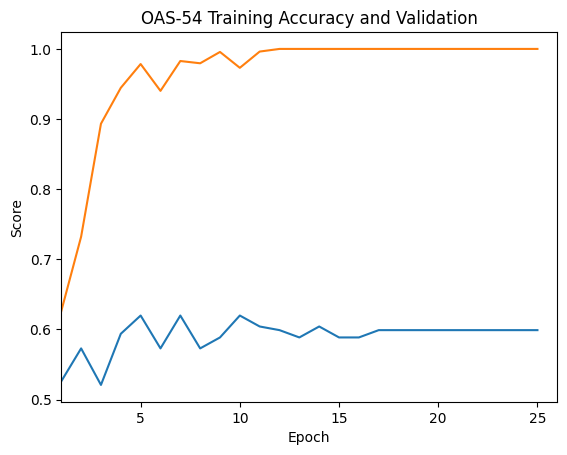

In [12]:
if os.getenv("TRAINMODEL") == "1":
  df_h = pd.DataFrame({"Epoch":np.arange(1, 26, 1), "Validation_accuracy":history.history['val_accuracy'],"Training_accuracy":history.history['accuracy']})
  df_h.to_excel(os.getenv("TRAININGTAB"))
else:
  df_h = pd.read_excel(os.getenv("TRAININGTAB"))

plt.plot(df_h["Epoch"],df_h["Validation_accuracy"], label="Validation Accuracy")
plt.plot(df_h["Epoch"],df_h["Training_accuracy"], label="Training Accuracy")

plt.title("OAS-54 Training Accuracy and Validation")
plt.xlim(1,26)

plt.xlabel("Epoch")
plt.ylabel("Score")

plt.savefig("training-validation.png", bbox_inches="tight")
plt.show()

In [13]:
if os.getenv("MAKEPREDICTIONS") =="1":
  predictions = []
  fileList = []
  mriID = []
  groups = []
  slice = []
  df_old = df.copy(deep=True)
  conf = []
  shap_acc  = []
  i = 0


  for root, dir, files in os.walk(os.path.join(os.getenv("JPG"), "test")):
    for f in files:
      g = getImgGroup(f, df)

      img = keras.preprocessing.image.load_img(os.path.join(root, f), target_size=data_shape[:3])
      img_arr = keras.preprocessing.image.img_to_array(img)
      img_arr = tf.expand_dims(img_arr, 0)
      groups += [g]
      slice += [f[-6:-4]]
      mriID += [f[:13]]
      fileList += [f]
      p = model.predict(img_arr)
      conf += [abs(p[0][0]-p[0][1])]
      predictions += [np.argmax(p)]

      print(f'{i:2d} ({i*100./280.:.2f}%)')
      i += 1

  df_predictions = pd.DataFrame({"MRI ID": mriID, "File": fileList, "Slice": slice, "Group": groups, "Prediction": predictions, "Confidence":conf})

  tf_a = []
  for index, row in df_predictions.iterrows():
    p = row["Prediction"]
    g = row["Group"]
    tf_a += [1 if g == p else 0]

  df_predictions["TF"] = tf_a

  df_predictions.to_excel(os.getenv("PREDICTTAB"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
 0 (0.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
 1 (0.36%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
 2 (0.71%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
 3 (1.07%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 4 (1.43%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
 5 (1.79%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
 6 (2.14%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 7 (2.50%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 8 (2.86%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
 9 (3.21%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
10 (3.57%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
11 (3.93%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
12 (4.29%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13 (4.64%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
14 (5.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
15 (5.36%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
16 (5.71%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
17 (6.07%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
18 (6.43%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
19 (6.79%)
1/1 ━━━━━━━━━━━━━━━━━━